<a href="https://colab.research.google.com/github/scottspurlock/mlfairness/blob/main/fair_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating synthetic tabular data with MDN
## Scott Spurlock
### 6/28/2021
Train an autoencoder along with an MDN to learn the distribution over the latent space to generate synthetic samples.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For MDN
import tensorflow_probability as tfp

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print(tf.__version__)
# !nvidia-smi

2.5.0


In [2]:
latent_dim = 8
epochs = 50
batch_size = 128
learning_rate = 5e-4
num_components = 5

## Load data

In [3]:
# Source: https://fairmlbook.org/code/adult.html
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

# Drop Na values in train and test sets
original_train = original_train.dropna()
original_test = original_test.dropna()

num_train = len(original_train)
num_test = len(original_test)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
original.drop(['Target', 'Education', 'fnlwgt'], axis = 1, inplace = True)
original


,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
16276,39,Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
16278,38,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
16279,44,Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


## Preprocessing
Make data numeric. Instead of one-hot encoding, we'll try just encoding as numeric values to hopefully improve data generation.

In [5]:
# numeric = pd.get_dummies(original)
# numeric.head()

categorical_features = ['Workclass', 'Martial Status', 'Occupation', 'Country','Relationship', 'Race', 'Sex']
continuous_features = ['Age','Capital Gain', 'Capital Loss', 'Hours per week']

numeric = original.copy()

for column in categorical_features:
  numeric[column] = numeric[column].astype('category').cat.codes

# Next, we will encode all continuous features to equally sized bins.
# for column in continuous_features:
#   min = numeric[column].min()
#   max = numeric[column].max()
#   feature_bins = pd.cut(numeric[column], bins=7, labels=False)
#   numeric.drop([column], axis=1, inplace=True)
#   numeric = pd.concat([numeric, feature_bins], axis=1)

numeric

,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,5,13,4,0,1,4,1,2174,0,40,38
1,50,4,13,2,3,0,4,1,0,0,13,38
2,38,2,9,0,5,1,4,1,0,0,40,38
3,53,2,7,2,5,0,2,1,0,0,40,38
4,28,2,13,2,9,5,2,0,0,0,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,2,13,4,9,3,4,1,0,0,40,38
16276,39,2,13,0,9,1,4,0,0,0,36,38
16278,38,2,13,2,9,0,4,1,0,0,50,38
16279,44,2,13,0,0,3,1,1,5455,0,40,38


In [6]:
X = numeric.values
y = labels.values.astype(np.float32)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

# We need to split the data into train and test sets before normalizing.
scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.PowerTransformer()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

# Convert to TF Dataset for ease of training
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

In [7]:
ytrain[:10]

array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1.], dtype=float32)

## Create the model

In [8]:
def classifier(in_dim):
    inputs = keras.Input(shape=in_dim, name='input_layer')
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, output, name='classifier')
    return model

In [9]:
def encoder(in_dim, embedded_dim):
    inputs = keras.Input(shape=(in_dim,), name='input_layer')
    x = layers.Dense(embedded_dim, activation="relu")(inputs)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [10]:
def decoder(in_dim, out_dim):
    # Assuming that data has been min-max normalized, then the output has
    # sigmoid activation to put things in the 0 to 1 range.
    # Note that the input dimensionality to the decoder is generally the same
    # as the output from the encoder (embedded dimensions)
    inputs = keras.Input(shape=(in_dim,), name='input_layer')
    x = layers.Dense(out_dim, activation="sigmoid")(inputs)
    model = tf.keras.Model(inputs, x, name='decoder')
    return model  

In [11]:
# Given the label, y, output the distribution over the latent space
def make_mdn_model(num_components=5, latent_dim=8):
    event_shape = [latent_dim]
    num_components = num_components
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    print('params_size:', params_size)

    input1 = keras.Input(shape=(1,), name='input_layer_target')
    x1 = layers.Dense(128, activation="relu", name='hidden_layer1')(input1)
    input2 = keras.Input(shape=(1,), name='input_layer_protected')
    x2 = layers.Dense(128, activation="relu", name='hidden_layer2')(input2)
    x = layers.Concatenate(axis=1)([x1, x2])
    x = layers.Dense(params_size, activation=None, name='penultimate_layer')(x)
    outp = tfp.layers.MixtureNormal(num_components=num_components, event_shape=event_shape)(x)
    model = tf.keras.Model([input1, input2], outp, name="mdn")
    return model

params_size: 85


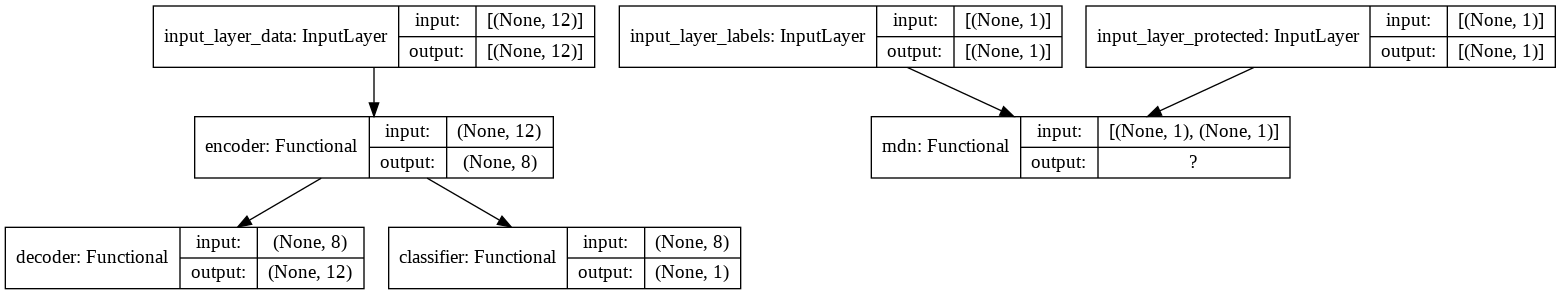

In [12]:
n_train, n_dim = Xtrain.shape

enc = encoder(n_dim, latent_dim)
dec = decoder(latent_dim, n_dim)
clf = classifier(latent_dim)
mdn = make_mdn_model(num_components, latent_dim)

input_data = keras.Input(shape=(n_dim,), name='input_layer_data')
input_labels = keras.Input(shape=(1,), name='input_layer_labels')
input_protected = keras.Input(shape=(1,), name='input_layer_protected')

model = tf.keras.Model(
			inputs=[input_data, input_labels, input_protected],
			outputs=[enc(input_data), dec(enc(input_data)), clf(enc(input_data)), mdn([input_labels, input_protected])],
			name="mdn_ae")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)


In [13]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure(figsize=(10, 10))
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()


In [14]:
loss_func_dec = tf.keras.losses.mean_squared_error
loss_func_mdn = lambda y, q: -q.log_prob(y)
loss_func_clf = tf.keras.losses.binary_crossentropy
loss_func_entropy = lambda w: -tf.reduce_sum(w * tf.math.log(w), axis=1)
# lw = [1000, 1, 100, 1]
lw = [1, 1, 100, 1]

opt = keras.optimizers.Adam(learning_rate=learning_rate)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    X, y = batch
    y = tf.reshape(y, [-1, 1])

    # HACK: pull out protected attribute - hardcoded column 7
    s = X[:, 7]

    # print('DEBUG train_step:', X.shape, y.shape)

    with tf.GradientTape() as tape:
      # Forward pass
      z, Xhat, yhat, gmm = model([X, y, s])
      # print('  ending forward pass...')

      # Losses
      loss_dec = loss_func_dec(X, Xhat)
      # print('  loss_dec', loss_dec)
      loss_mdn = loss_func_mdn(z, gmm)
      # print('  loss_mdn', loss_mdn)
      # print('  classifier loss... y', y.shape, ', yhat', yhat.shape)
      loss_clf = loss_func_clf(y, yhat)
      # print('  loss_clf', loss_clf)
      loss_entropy = -loss_func_entropy(gmm.mixture_distribution.probs_parameter())
      # print('  loss_entropy', loss_entropy)
      # loss_gmm_recon = tf.keras.losses.mean_squared_error(X, gmm.components_distribution.mean()[:, 0])
      loss = lw[0] * loss_dec + lw[1] * loss_mdn + lw[2] * loss_clf + lw[3]*loss_entropy #+ lw[4]*loss_gmm_recon
      # print('  total loss', loss)

    grads = tape.gradient(loss, model.trainable_variables)
    # print('DEBUG:\n', grads)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    # print('DEBUG ... ', y.dtype, yhat.dtype)
    acc_dec = tf.keras.metrics.binary_accuracy(y, yhat, 0.5)

    return tf.reduce_mean(loss, axis=None), \
           tf.reduce_mean(loss_dec, axis=None), \
           tf.reduce_mean(loss_mdn, axis=None), \
           tf.reduce_mean(loss_clf, axis=None), \
           tf.reduce_mean(loss_entropy, axis=None), \
           tf.reduce_mean(acc_dec, axis=None)

def train(dataset, epochs):
  # losses = np.zeros((epochs,))
  # Keep results for plotting
  train_loss_results = []
  train_accuracy_results = []

  for epoch in range(epochs):
    print('Epoch {:02d} of {:02d} ...'.format(epoch+1, epochs))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_dec = tf.keras.metrics.Mean()
    epoch_loss_mdn = tf.keras.metrics.Mean()
    epoch_loss_clf = tf.keras.metrics.Mean()
    epoch_loss_entropy = tf.keras.metrics.Mean()
    # epoch_loss_gmm_recon = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Mean()

    start = time.time()

    for curr_batch in dataset:
      ret = train_step(curr_batch)
      loss_value, loss_dec, loss_mdn, loss_clf, loss_entropy, acc_dec = ret

      # Track progress
      epoch_loss_avg.update_state(loss_value)  # Add current batch loss
      epoch_loss_dec.update_state(loss_dec)  
      epoch_loss_mdn.update_state(loss_mdn)  
      epoch_loss_clf.update_state(loss_clf)  
      epoch_loss_entropy.update_state(loss_entropy)  
      # epoch_loss_gmm_recon.update_state(loss_gmm_recon)  
      epoch_accuracy.update_state(acc_dec)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 1 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, DEC: {:.3f}, MDN: {:.3f}, CLF: {:.3f}, ENT: {:.3f}, Acc: {:.3%}".format(epoch+1,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_loss_dec.result(),
                                                                  epoch_loss_mdn.result(),
                                                                  epoch_loss_clf.result(),
                                                                  epoch_loss_entropy.result(),
                                                                  epoch_accuracy.result()))
    
    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print('  over {} batches, avg loss is {:.4f}'.format(batches, avg_loss))

    # ---------
    # Show examples


  return train_loss_results, train_accuracy_results


Epoch 01 of 50 ...
Epoch 001: Loss: 51.117, DEC: 0.124, MDN: -2.928, CLF: 0.554, ENT: -1.473, Acc: 74.209%
Time for epoch 1 is 4.416453838348389 sec
Epoch 02 of 50 ...
Epoch 002: Loss: 32.538, DEC: 0.103, MDN: -17.438, CLF: 0.513, ENT: -1.422, Acc: 75.046%
Time for epoch 2 is 2.55263352394104 sec
Epoch 03 of 50 ...
Epoch 003: Loss: 26.510, DEC: 0.092, MDN: -19.831, CLF: 0.476, ENT: -1.375, Acc: 76.807%
Time for epoch 3 is 2.550607442855835 sec
Epoch 04 of 50 ...
Epoch 004: Loss: 20.770, DEC: 0.086, MDN: -22.279, CLF: 0.443, ENT: -1.336, Acc: 79.566%
Time for epoch 4 is 1.8910465240478516 sec
Epoch 05 of 50 ...
Epoch 005: Loss: 13.805, DEC: 0.082, MDN: -27.016, CLF: 0.421, ENT: -1.329, Acc: 81.502%
Time for epoch 5 is 2.5523226261138916 sec
Epoch 06 of 50 ...
Epoch 006: Loss: 9.606, DEC: 0.079, MDN: -29.956, CLF: 0.408, ENT: -1.322, Acc: 81.935%
Time for epoch 6 is 2.550568103790283 sec
Epoch 07 of 50 ...
Epoch 007: Loss: 8.156, DEC: 0.076, MDN: -30.513, CLF: 0.399, ENT: -1.316, Acc: 82

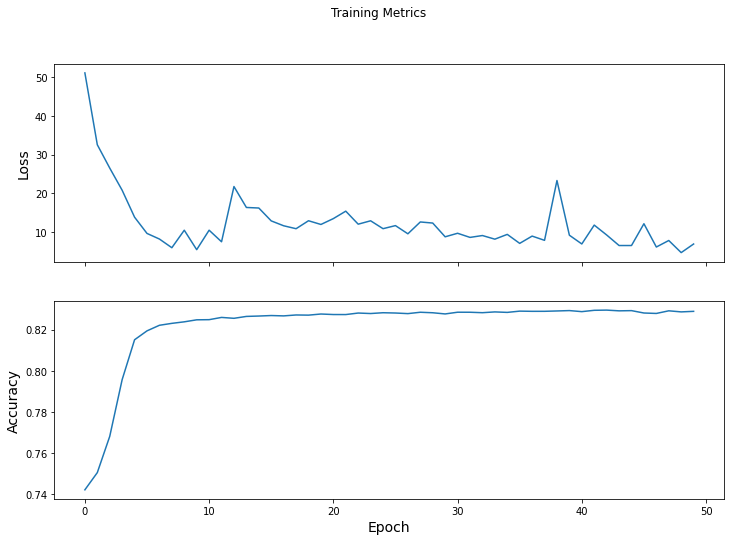

In [15]:
train_loss_results, train_accuracy_results = train(train_dataset, epochs)

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


Test Accuracy: 0.8268592909265129
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     10258
         1.0       0.70      0.52      0.59      3309

    accuracy                           0.83     13567
   macro avg       0.78      0.72      0.74     13567
weighted avg       0.82      0.83      0.82     13567



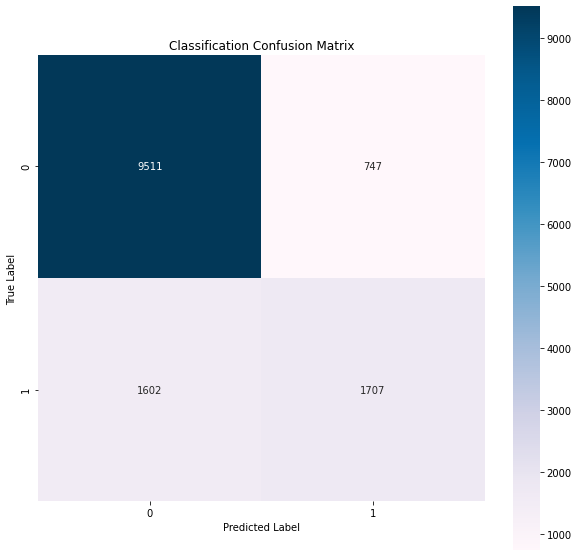

In [16]:
# Check accuracy

# Encode the input image
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy:', acc)

print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


0 - 0 :  ( -0.14568932019976008 0.0516916248236926 )   2.0890432596206665 1.0460713505744934
0 - 1 :  ( -0.060584423437955025 0.11345074505803601 )   2.089243084192276 1.2725619971752167
0 - 2 :  ( -0.03719010899883135 0.007476620384764638 )   11.644351482391357 1.280258595943451
0 - 3 :  ( 0.0009436520101110003 0.0774114962030287 )   2.0888759195804596 1.1551160365343094
0 - 4 :  ( -0.14967397172755484 0.02599452063429352 )   2.0884862542152405 1.621723622083664
1 - 0 :  ( -0.22220331621588174 0.24051159041221581 )   2.0888346433639526 0.23731917142868042
1 - 1 :  ( 0.12567632580072843 -0.19420508488712762 )   2.0893828570842743 0.3011862002313137
1 - 2 :  ( -0.016849326631538996 0.00530786968024076 )   11.644810438156128 0.5440932139754295
1 - 3 :  ( -0.0014886419956102181 0.27034768630845224 )   2.088061571121216 0.27363503351807594
1 - 4 :  ( -0.0200933492797057 -0.07950383683065707 )   2.0889097452163696 0.21695587784051895
2 - 0 :  ( -0.17400279993188736 -0.02337992338557227 )   

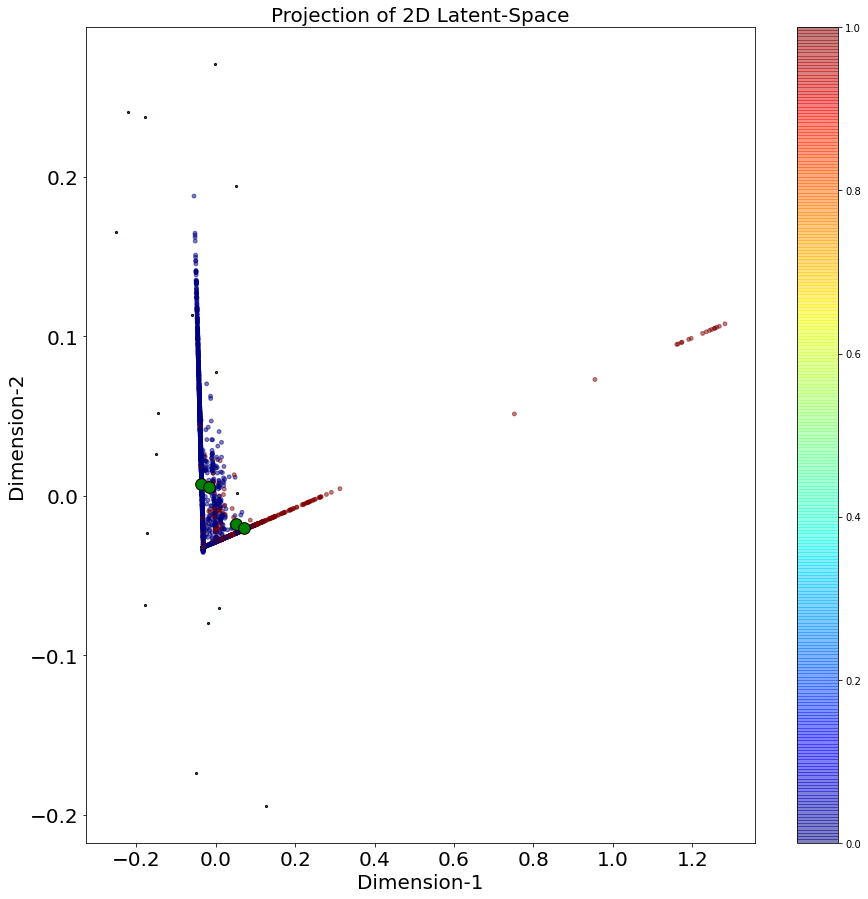

In [17]:
imgs_visualize = 3000
figsize = 15
show_gmm_modes = True

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(z)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)

    if show_gmm_modes:
      labels_income = np.array([[0], [0], [1], [1]])
      labels_sex = np.array([[0], [1], [0], [1]])
      gmm = mdn([labels_income, labels_sex], training=False)
      for i in range(4):
        for k in range(num_components):
          z = gmm.components_distribution.mean()[i, k].numpy()
          w = 20*gmm.mixture_distribution.probs_parameter().numpy()[i, k]
          s = gmm.components_distribution.stddev()[i, k].numpy()
          s = 10*np.linalg.norm(s)
          # print('Digit {:d} ({:d}): ({:.2f}, {:.2f}) {:.4f} {:.4f}'.format(i, k, z[0], z[1], w, s))
          if use_pca:
            # print(z.shape)
            z = np.reshape(z, (1, -1))
            # print(z.shape)
            z = pca.transform(z)
            # print(z.shape)
            z = np.reshape(z, (2,))

          print(i, '-', k, ':  (', z[0], z[1], ')  ', w, s)
          plt.plot(z[0], z[1], 'ok', MarkerSize=w, MarkerFaceColor='green')

    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(Xtrain[:imgs_visualize], ytrain[:imgs_visualize], True)


In [18]:
numeric.head(10)

,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,5,13,4,0,1,4,1,2174,0,40,38
1,50,4,13,2,3,0,4,1,0,0,13,38
2,38,2,9,0,5,1,4,1,0,0,40,38
3,53,2,7,2,5,0,2,1,0,0,40,38
4,28,2,13,2,9,5,2,0,0,0,40,4
5,37,2,14,2,3,5,4,0,0,0,40,38
6,49,2,5,3,7,1,2,0,0,0,16,22
7,52,4,9,2,3,0,4,1,0,0,45,38
8,31,2,14,4,9,1,4,0,14084,0,50,38
9,42,2,13,2,3,0,4,1,5178,0,40,38


In [19]:
labels_income = np.array([[0], [0], [1], [1]])
labels_sex = np.array([[0], [1], [0], [1]])

results = np.zeros((num_components*4, Xtest.shape[1]+3))
gmm = mdn([labels_income, labels_sex], training=False)

idx1 = 0
idx2 = 0

for idx1 in range(4):
  for k in range(num_components):
    z = gmm.components_distribution.mean()[idx1, k]
    z = tf.reshape(z, (1, -1))
    xhat = dec(z)
    xhat = scaler.inverse_transform(xhat)
    w = gmm.mixture_distribution.probs_parameter().numpy()[idx1, k]
    s = gmm.components_distribution.stddev()[idx1, k].numpy()
    results[idx2, 0] = labels_income[idx1]
    results[idx2, 1] = labels_sex[idx1]
    results[idx2, 2] = w
    results[idx2, 3:] = xhat
    idx2 += 1

disp = pd.DataFrame(results, columns=['Income', 'Sex', 'Weight']+list(numeric.columns.values))

for k in range(4):
  print(disp.iloc[k*num_components:(k+1)*num_components])

   Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
0     0.0  0.0     0.1  ...         160.7            34.8     35.8
1     0.0  0.0     0.1  ...         138.9            33.3     36.8
2     0.0  0.0     0.6  ...         151.3            39.7     36.2
3     0.0  0.0     0.1  ...         135.7            36.7     36.8
4     0.0  0.0     0.1  ...         163.4            36.0     35.5

[5 rows x 15 columns]
   Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
5     0.0  1.0     0.1  ...         145.0            25.0     36.7
6     0.0  1.0     0.1  ...         157.8            56.7     35.7
7     0.0  1.0     0.6  ...         149.7            40.4     36.4
8     0.0  1.0     0.1  ...          98.3            25.7     37.8
9     0.0  1.0     0.1  ...         164.8            46.3     35.7

[5 rows x 15 columns]
    Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
10     1.0  0.0     0.1  ...         172.5            38.1     35.0
11     1.0  0.

In [20]:
disp.Weight

0    0.1
1    0.1
2    0.6
3    0.1
4    0.1
      ..
15   0.1
16   0.1
17   0.6
18   0.1
19   0.1
Name: Weight, Length: 20, dtype: float64

In [21]:
!pip install table_evaluator


  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-cp37-none-any.whl size=17055 sha256=e4ed550775ed5add1dd0e64d8964583e0d21564f5433104b9b1bd19def13f3b3
  Stored in directory: /root/.cache/pip/wheels/a9/4d/9d/62b61486fc85b53ef9bf7979a52cda067a514c2a7a05c49bd4
Successfully built table-evaluator


In [22]:
from table_evaluator import load_data, TableEvaluator


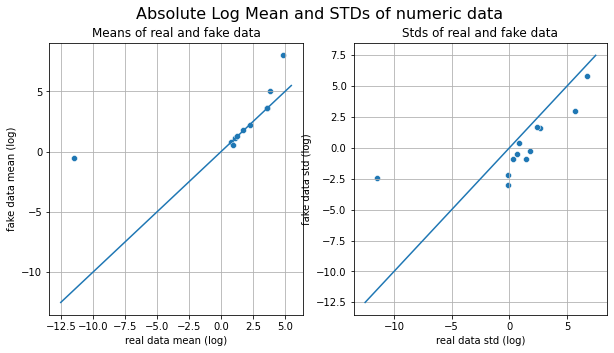

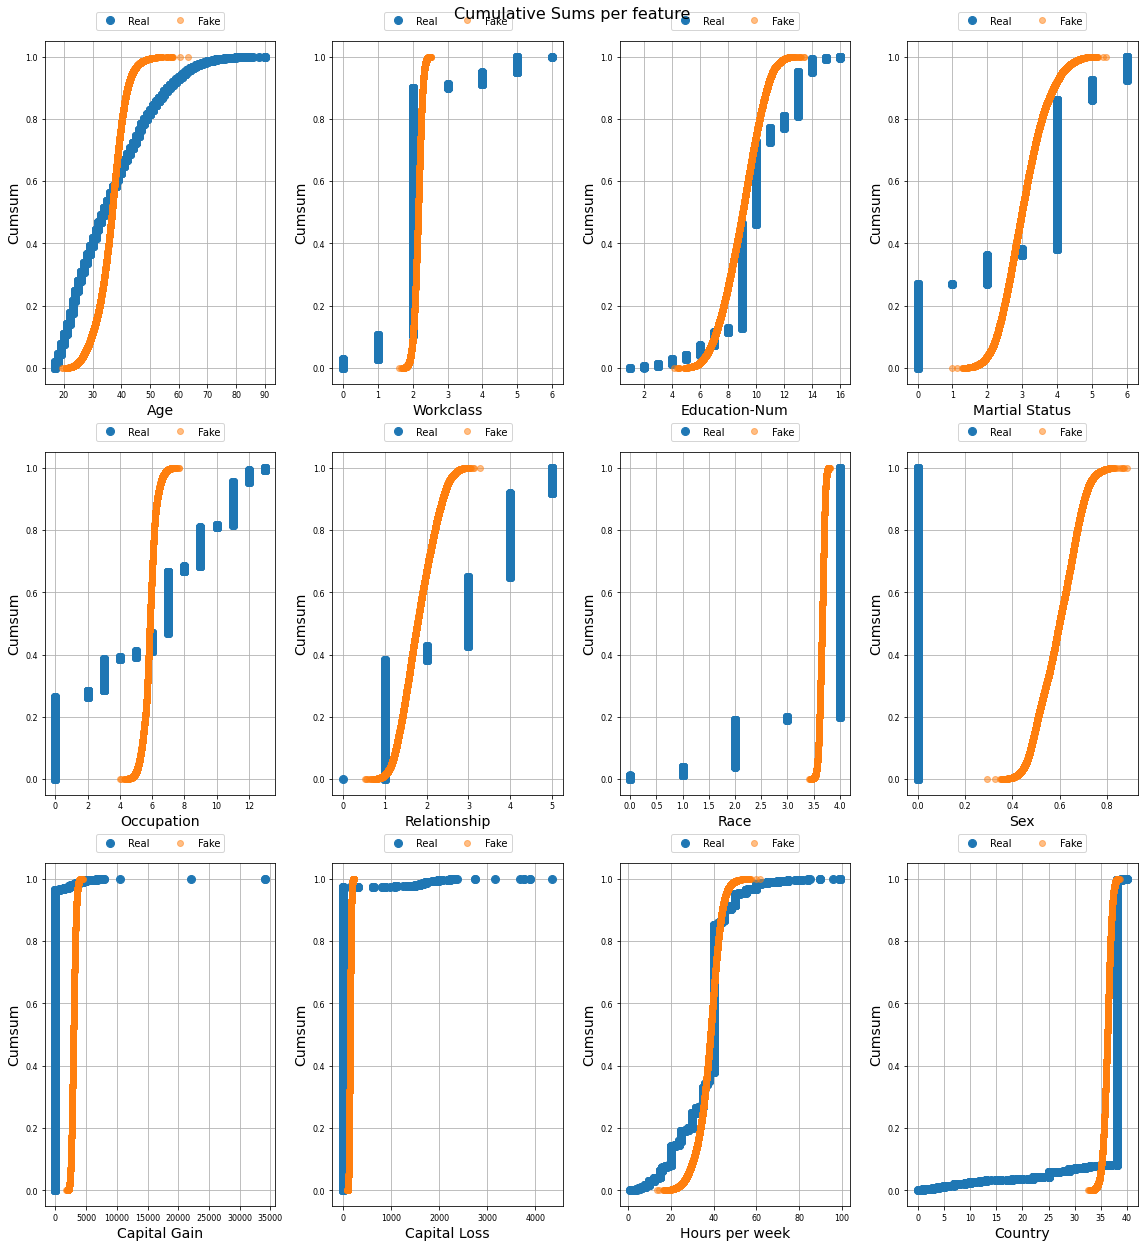

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

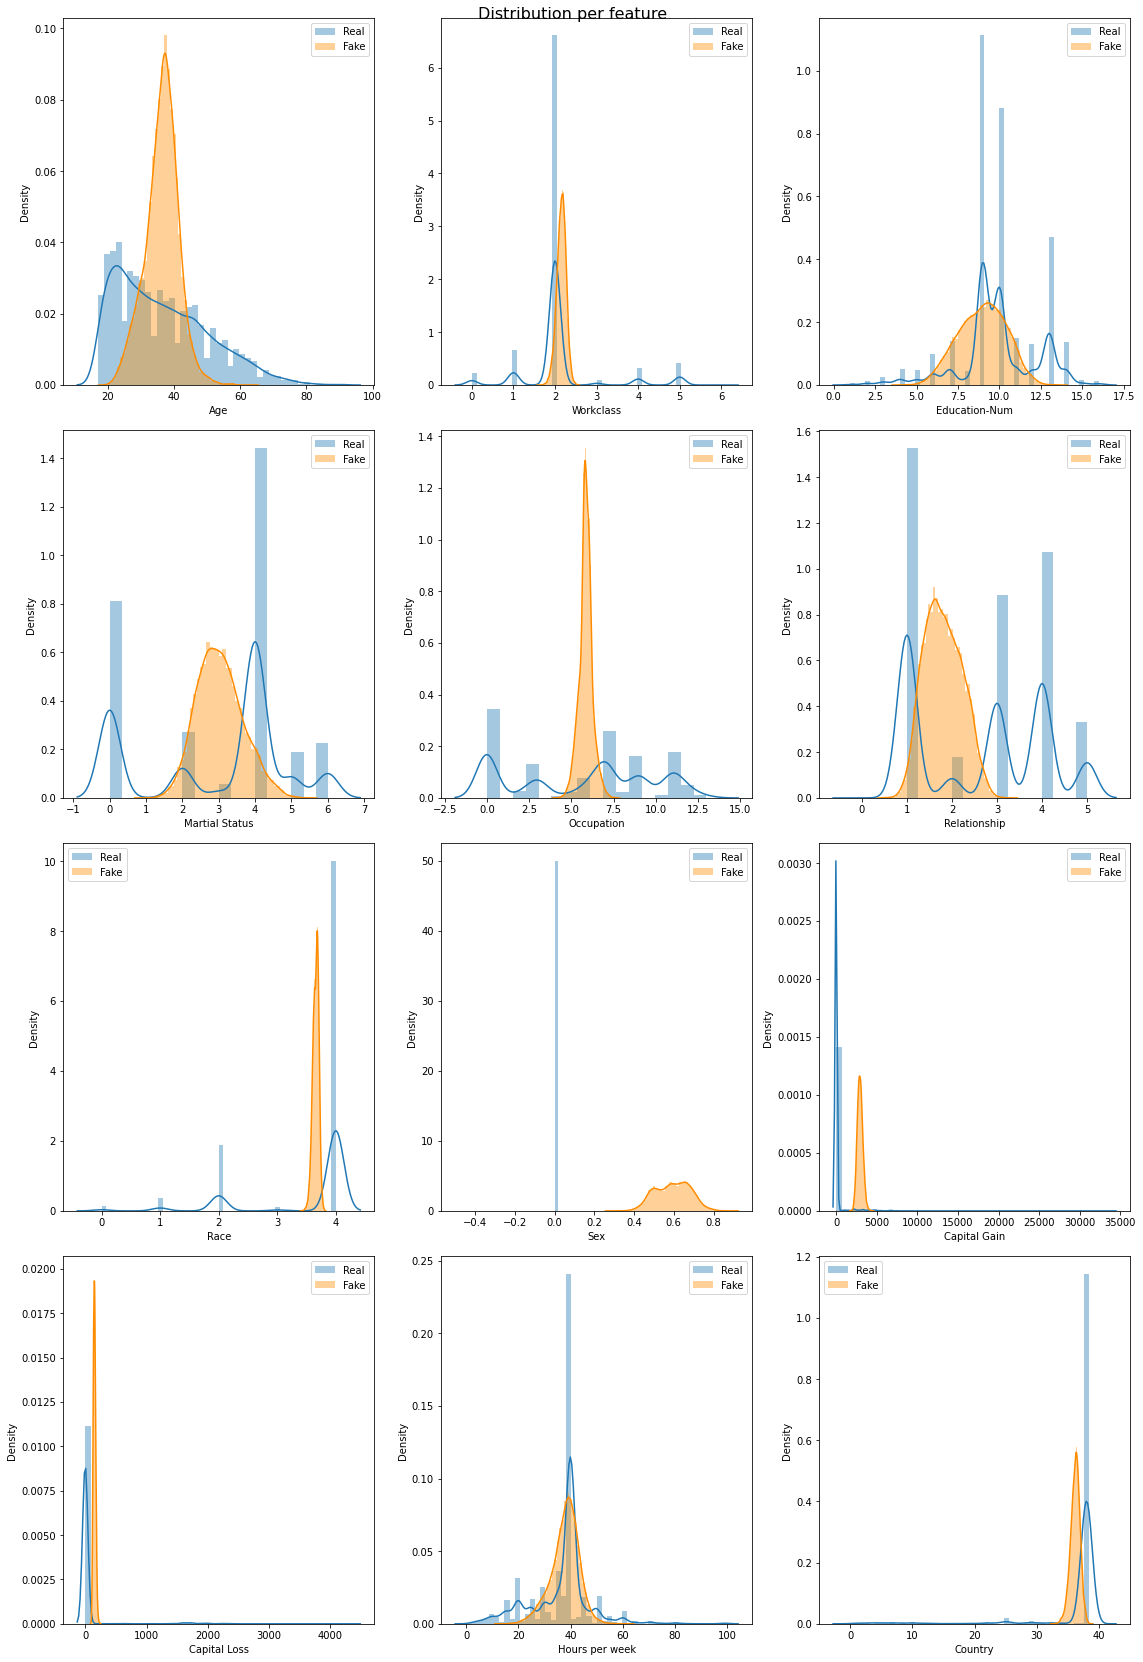

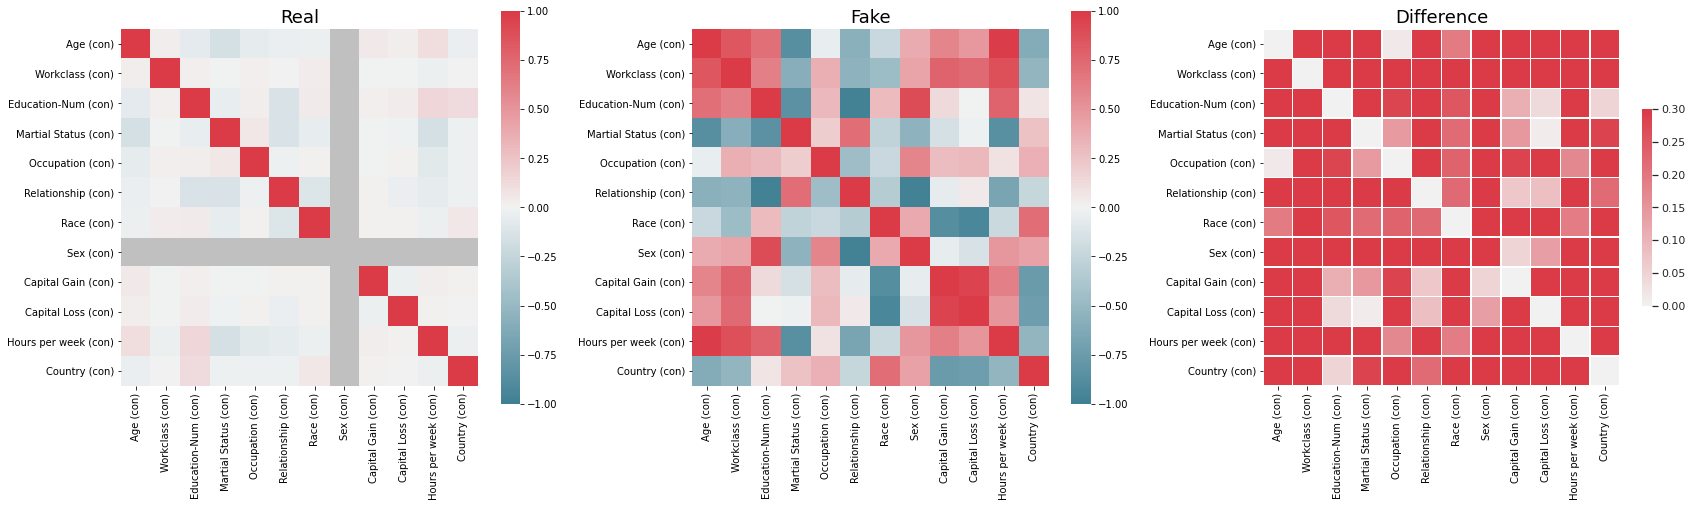

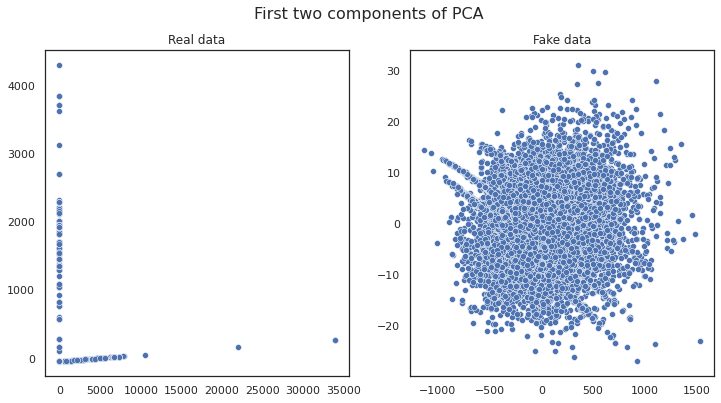

In [23]:
# Random sampling from the MDN

# Low income, female
# HACK: protecte attribute is column 7
mask = (y == 0) & (X[:, 7] == 0)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.zeros((num_samples, 1))
curr_protected = np.zeros((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

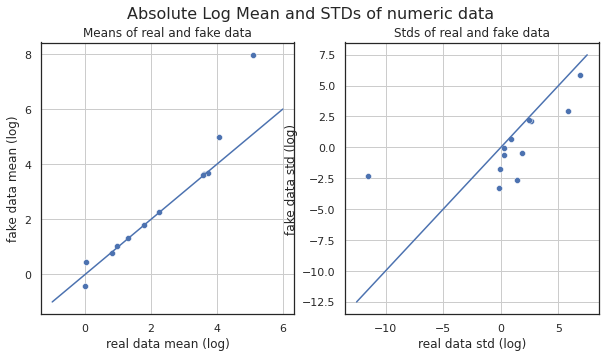

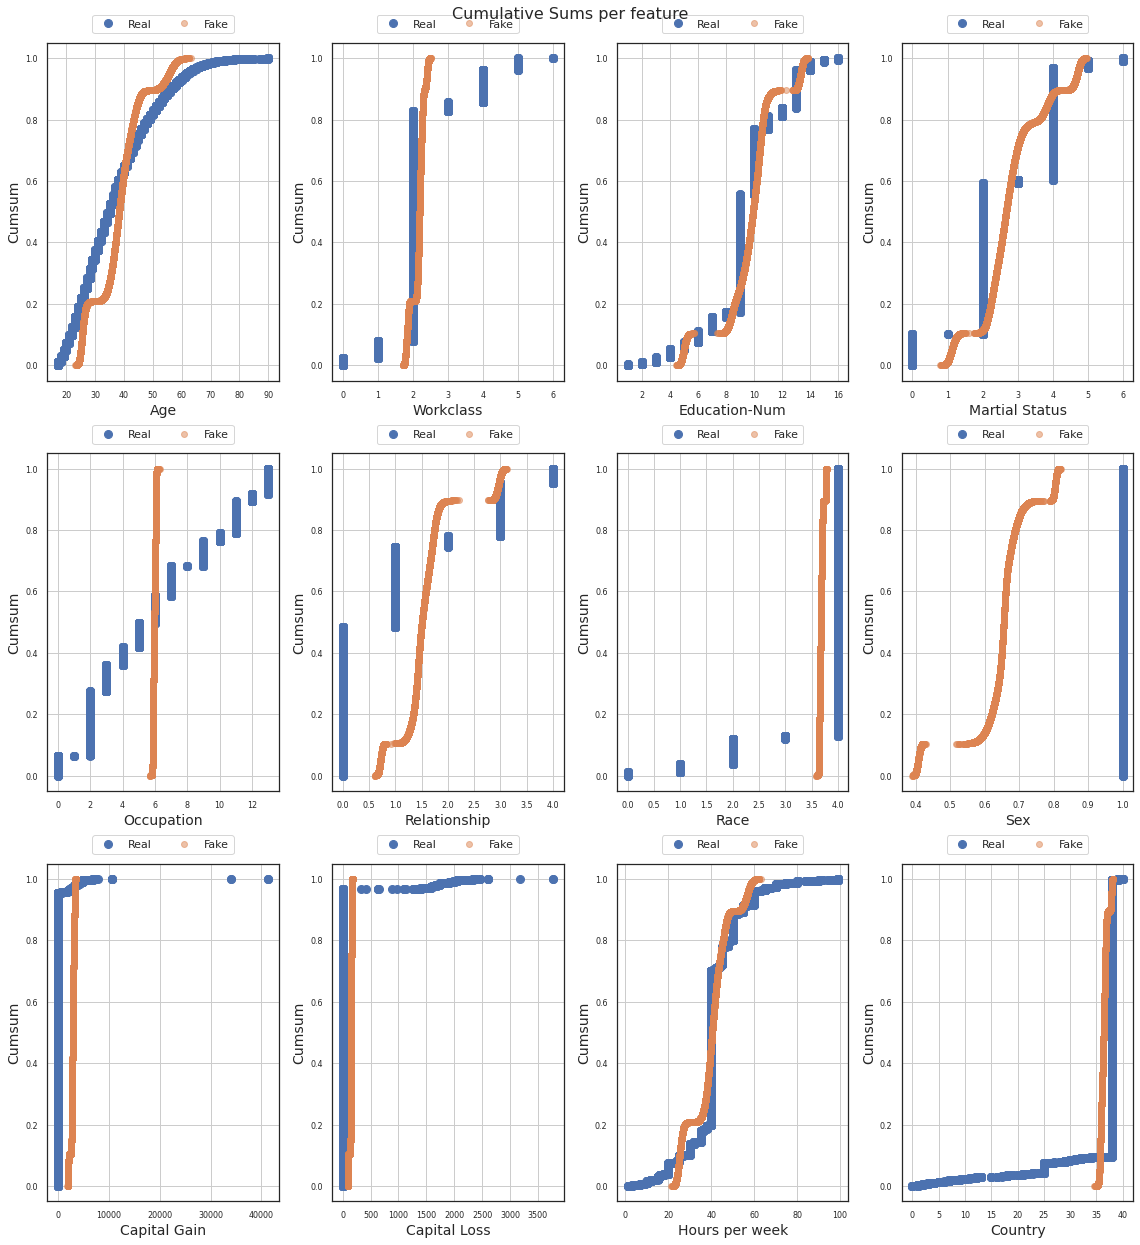

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

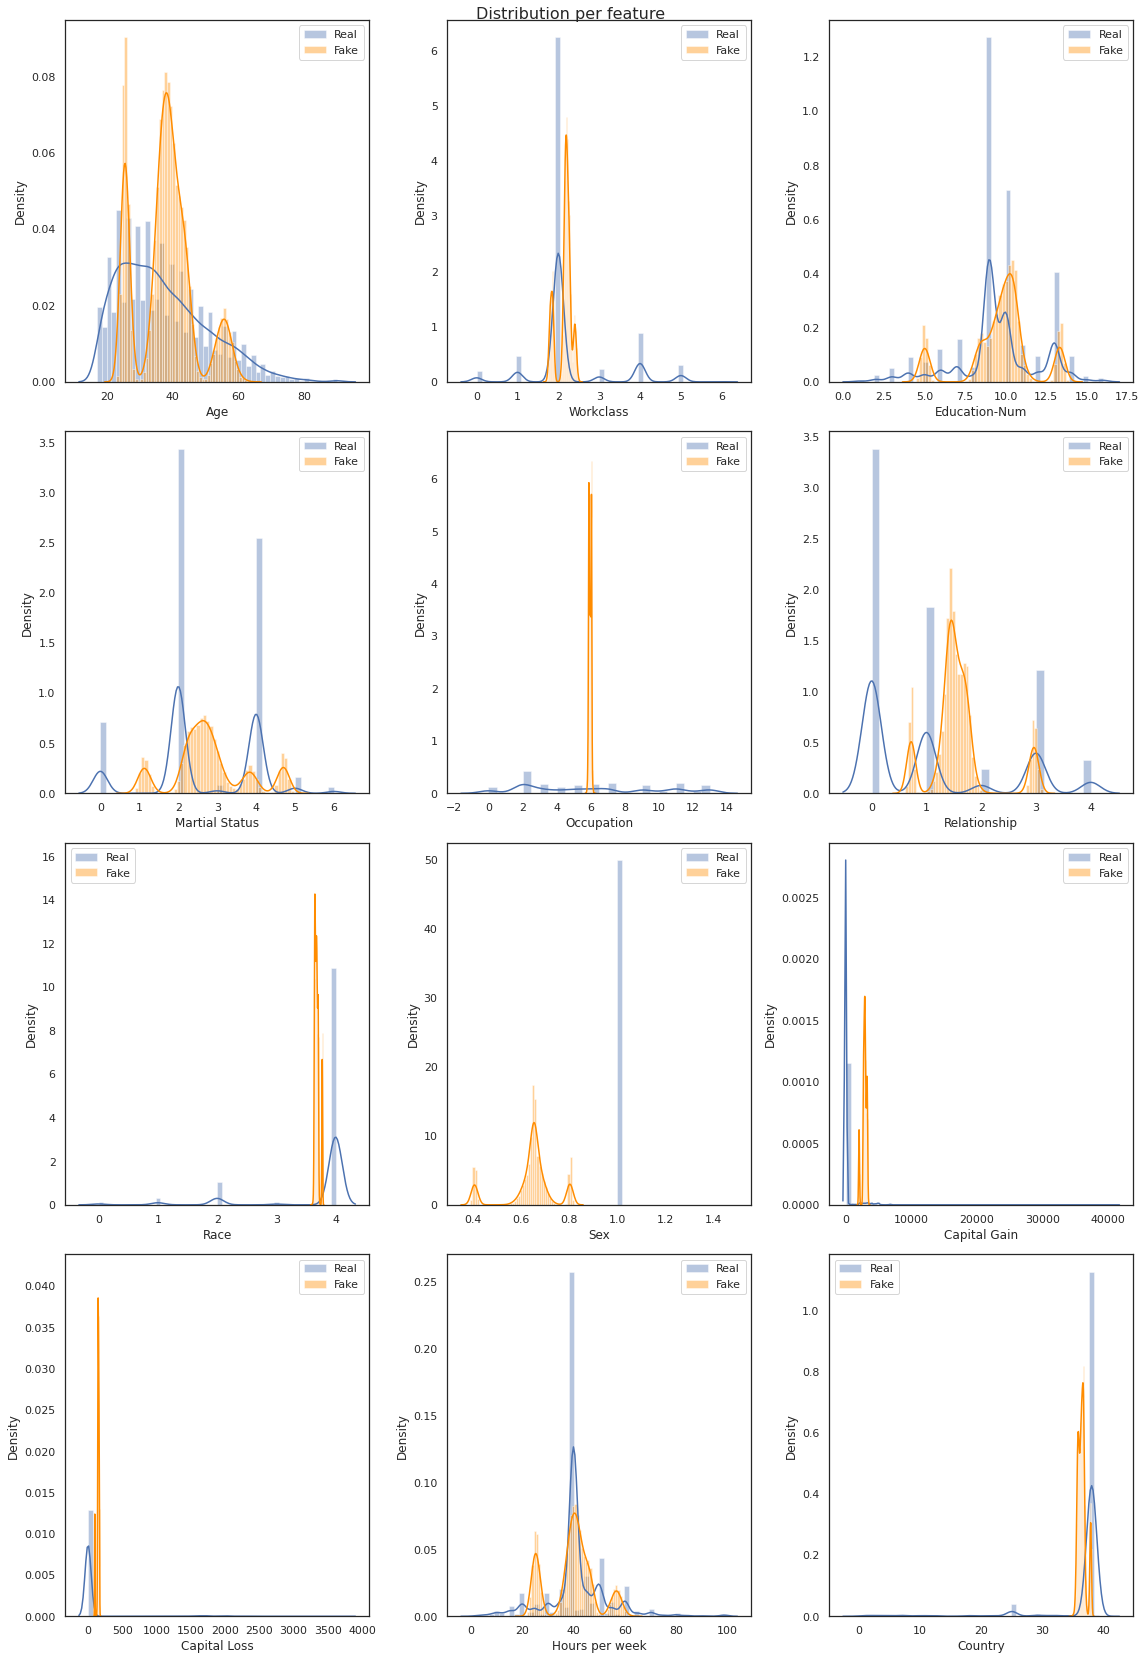

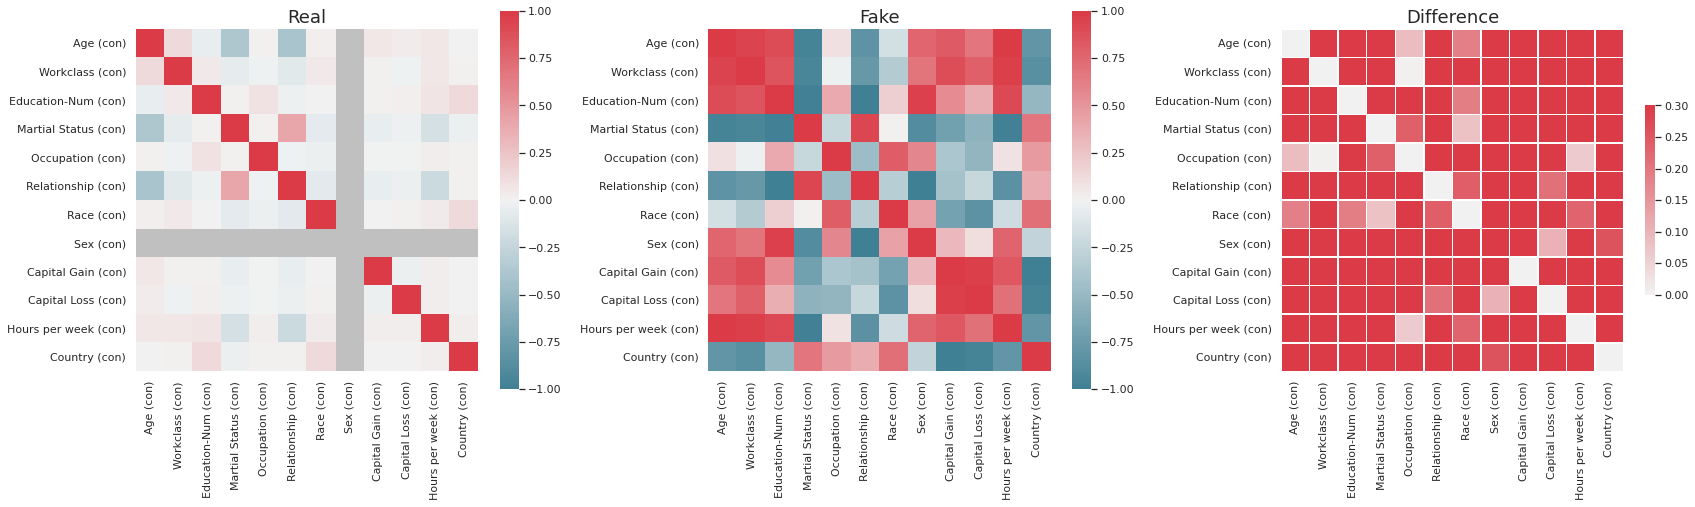

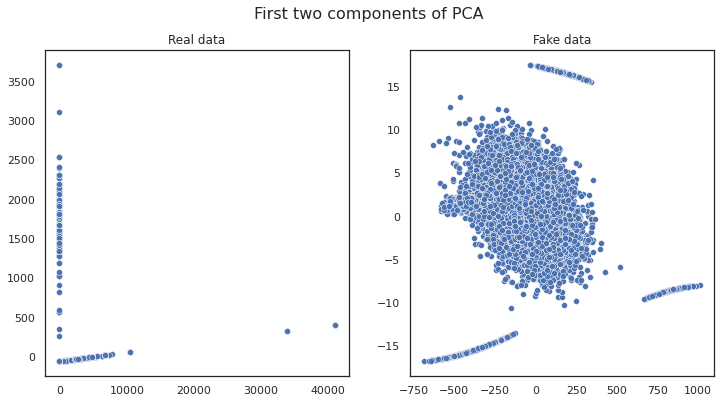

In [24]:
# Random sampling from the MDN

# Low income, male
# HACK: protecte attribute is column 7
mask = (y == 0) & (X[:, 7] == 1)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.zeros((num_samples, 1))
curr_protected = np.ones((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

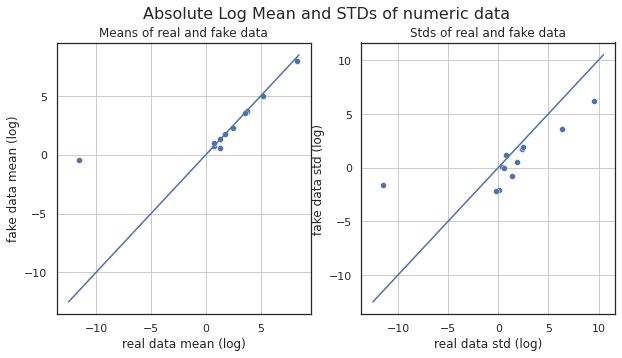

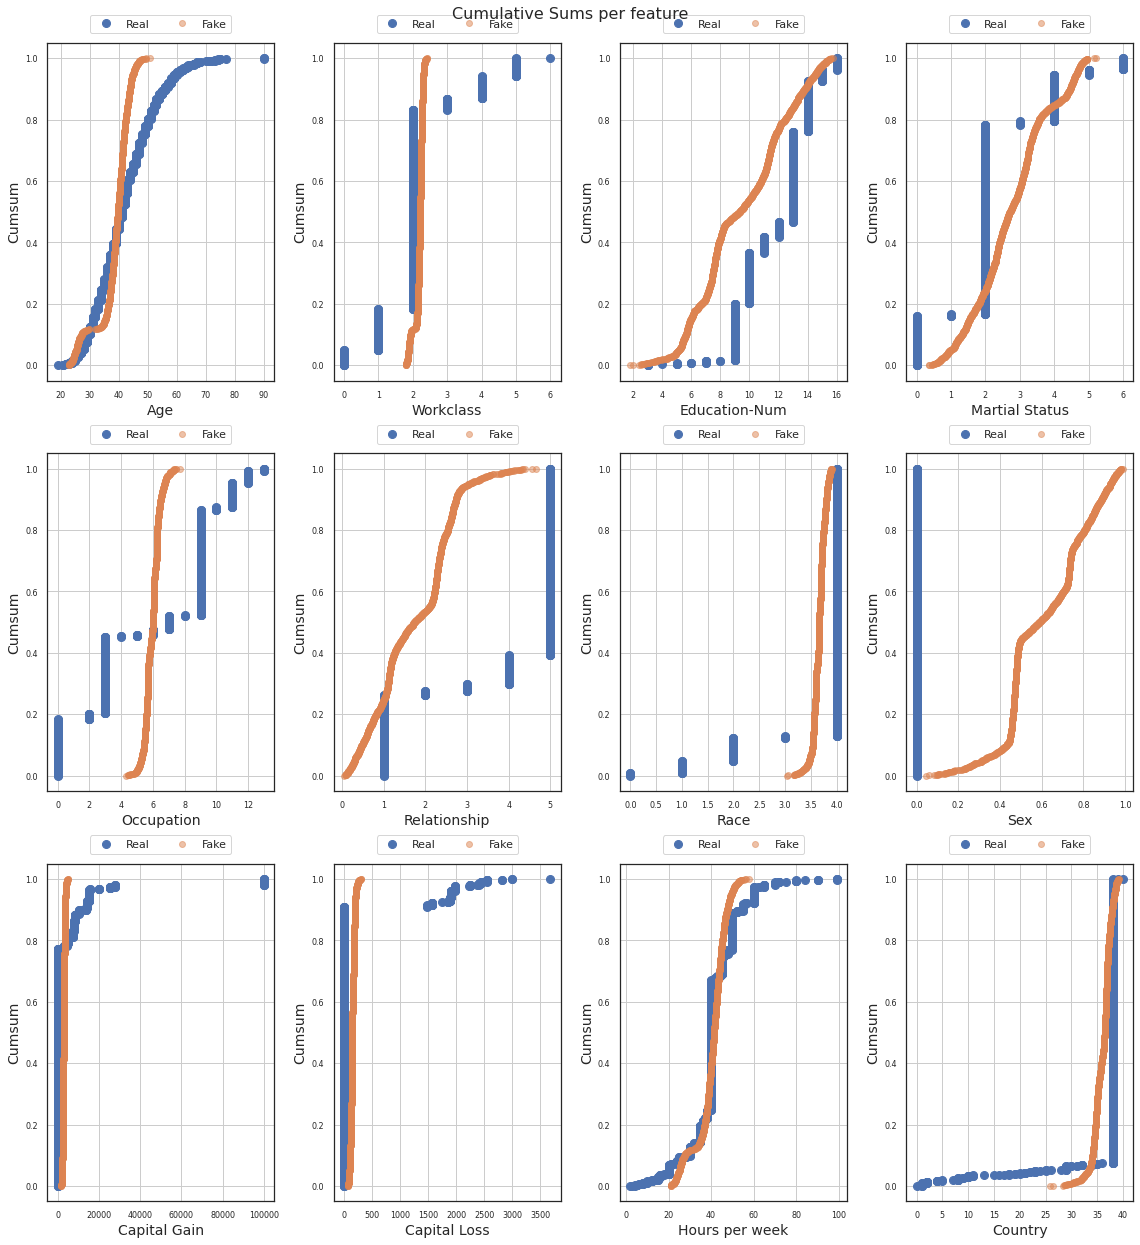

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

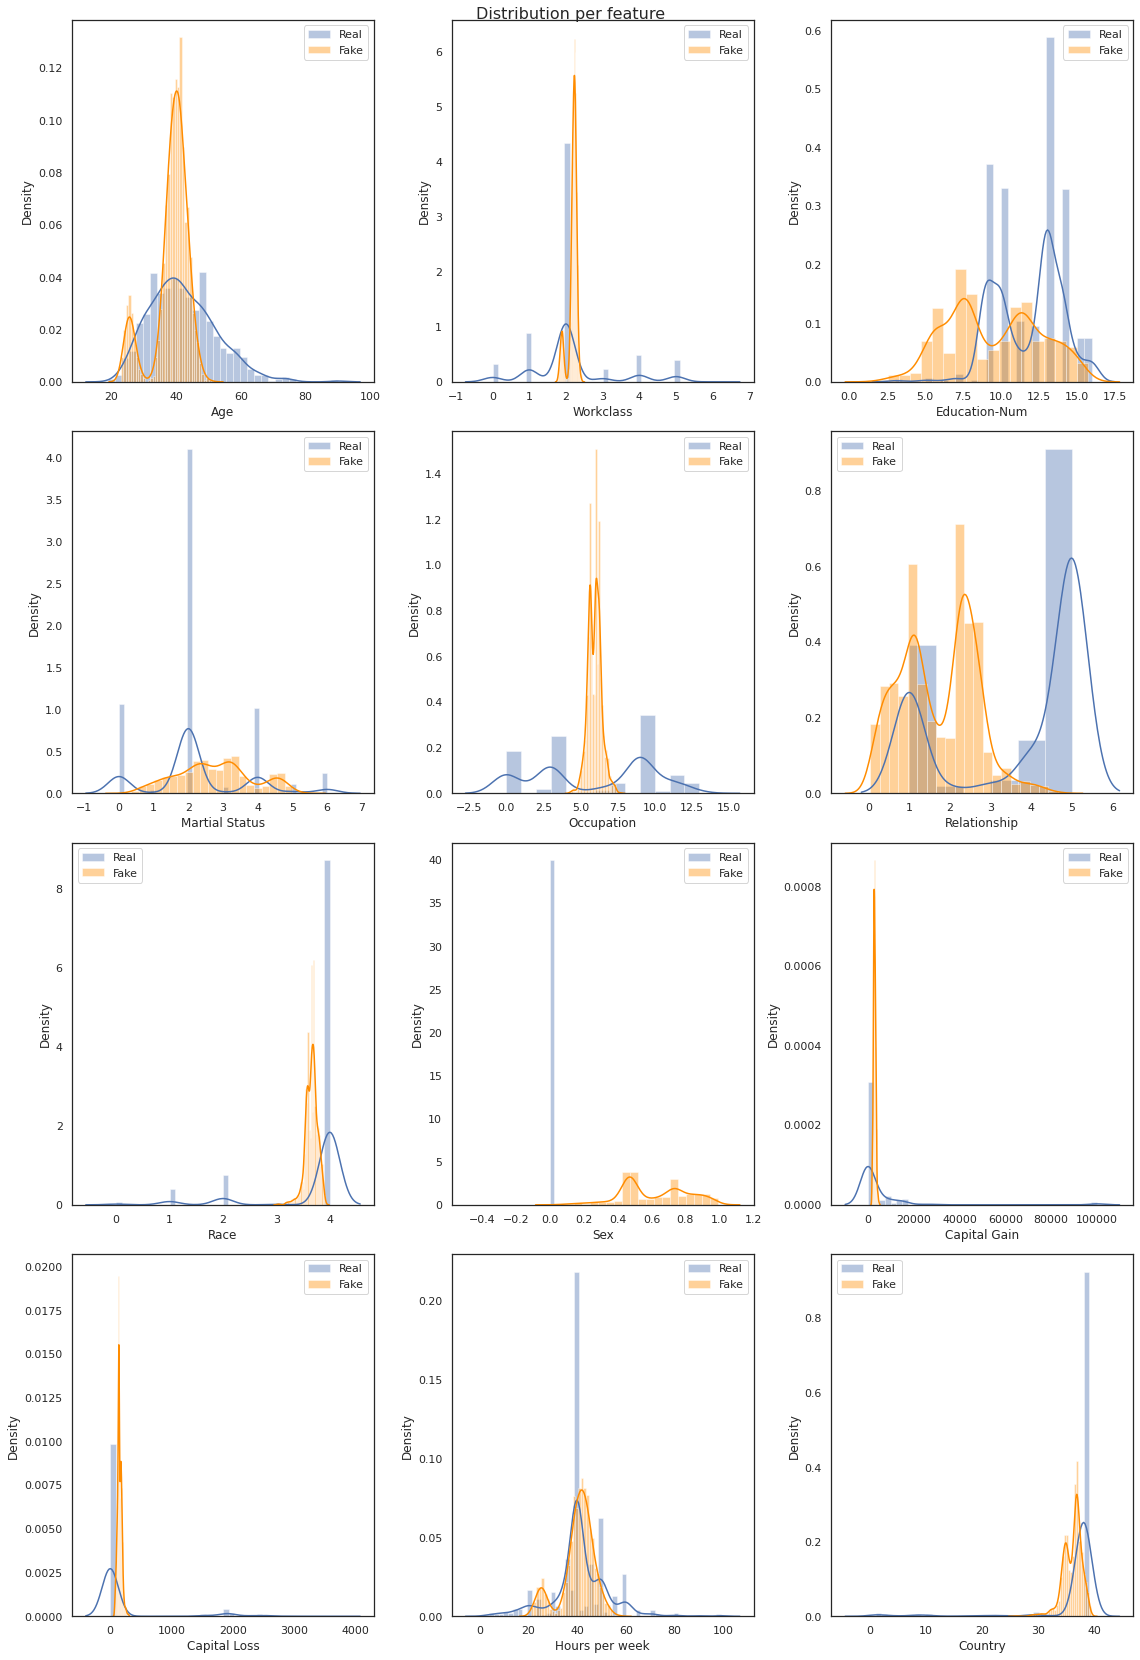

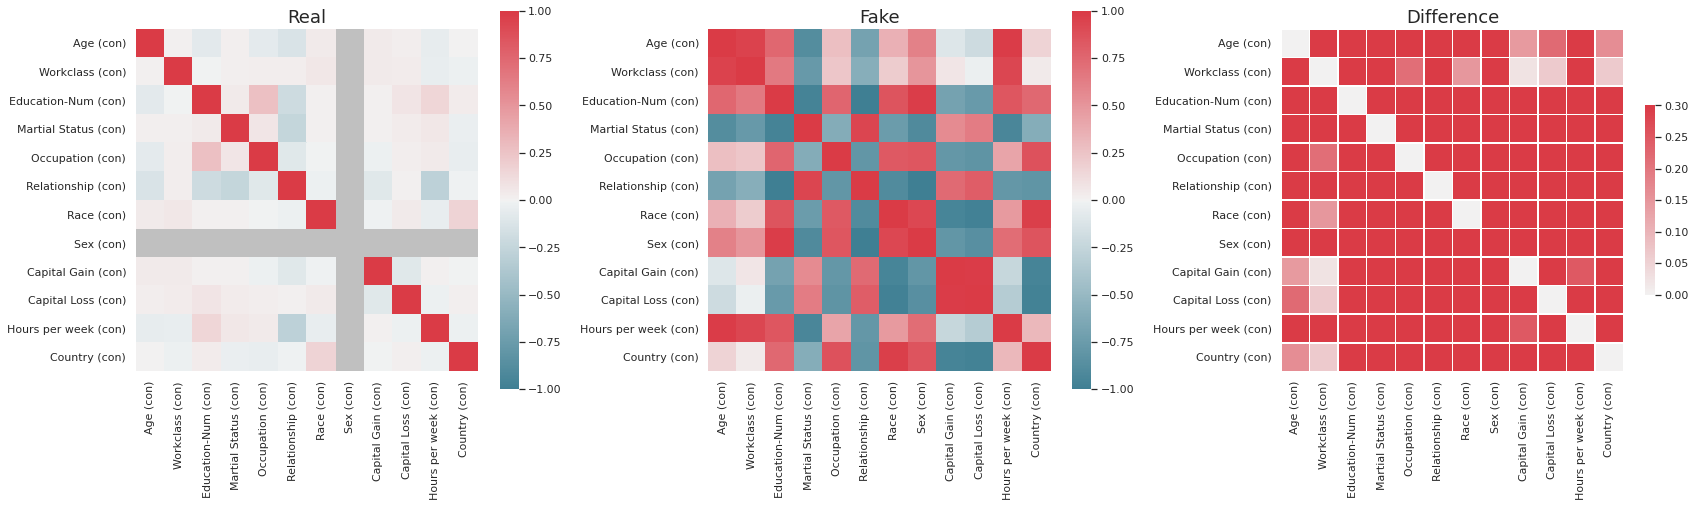

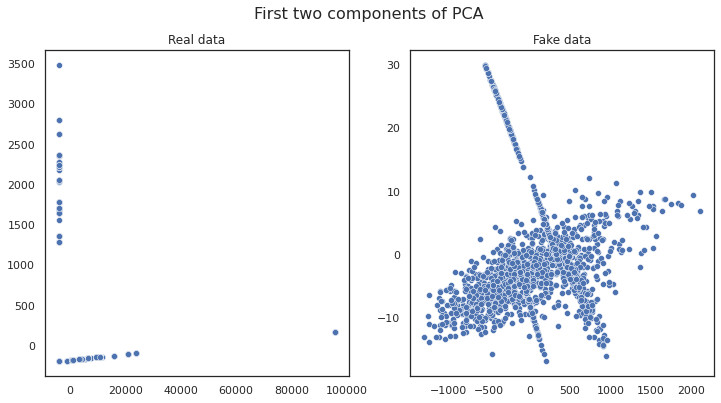

In [25]:
# Random sampling from the MDN

# High income, female
# HACK: protecte attribute is column 7
mask = (y == 1) & (X[:, 7] == 0)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.ones((num_samples, 1))
curr_protected = np.zeros((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

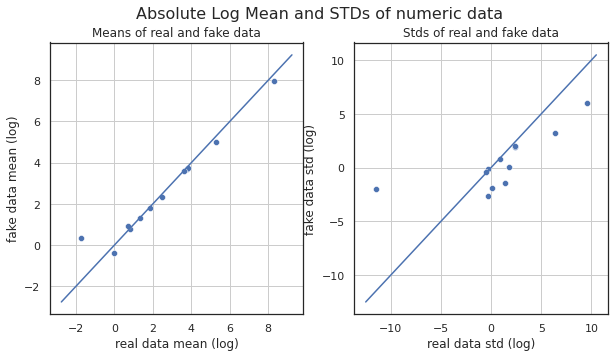

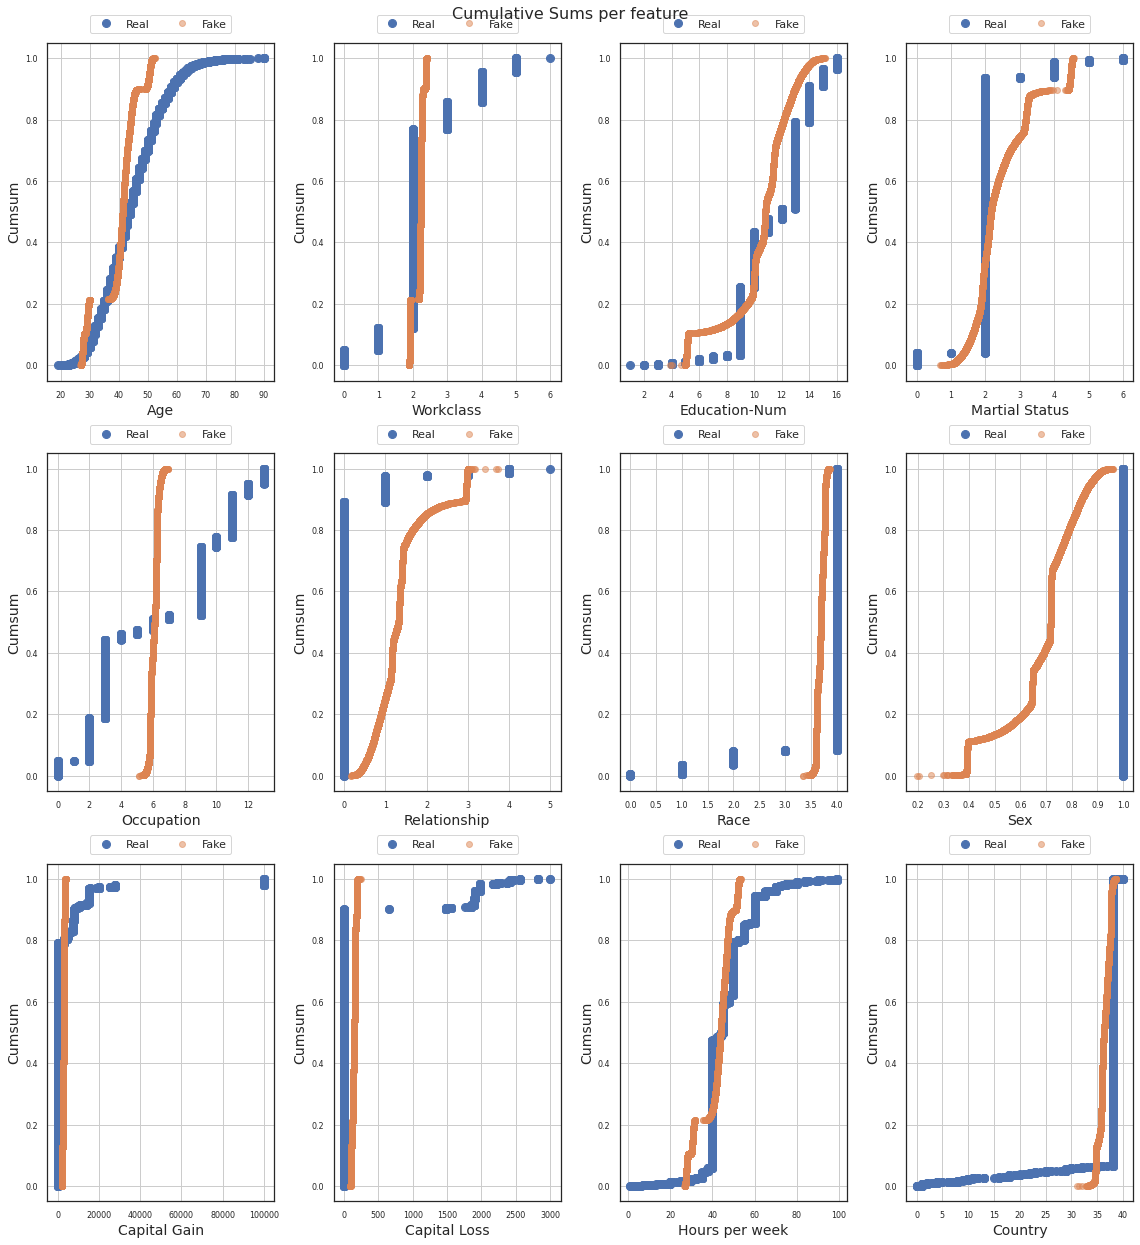

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

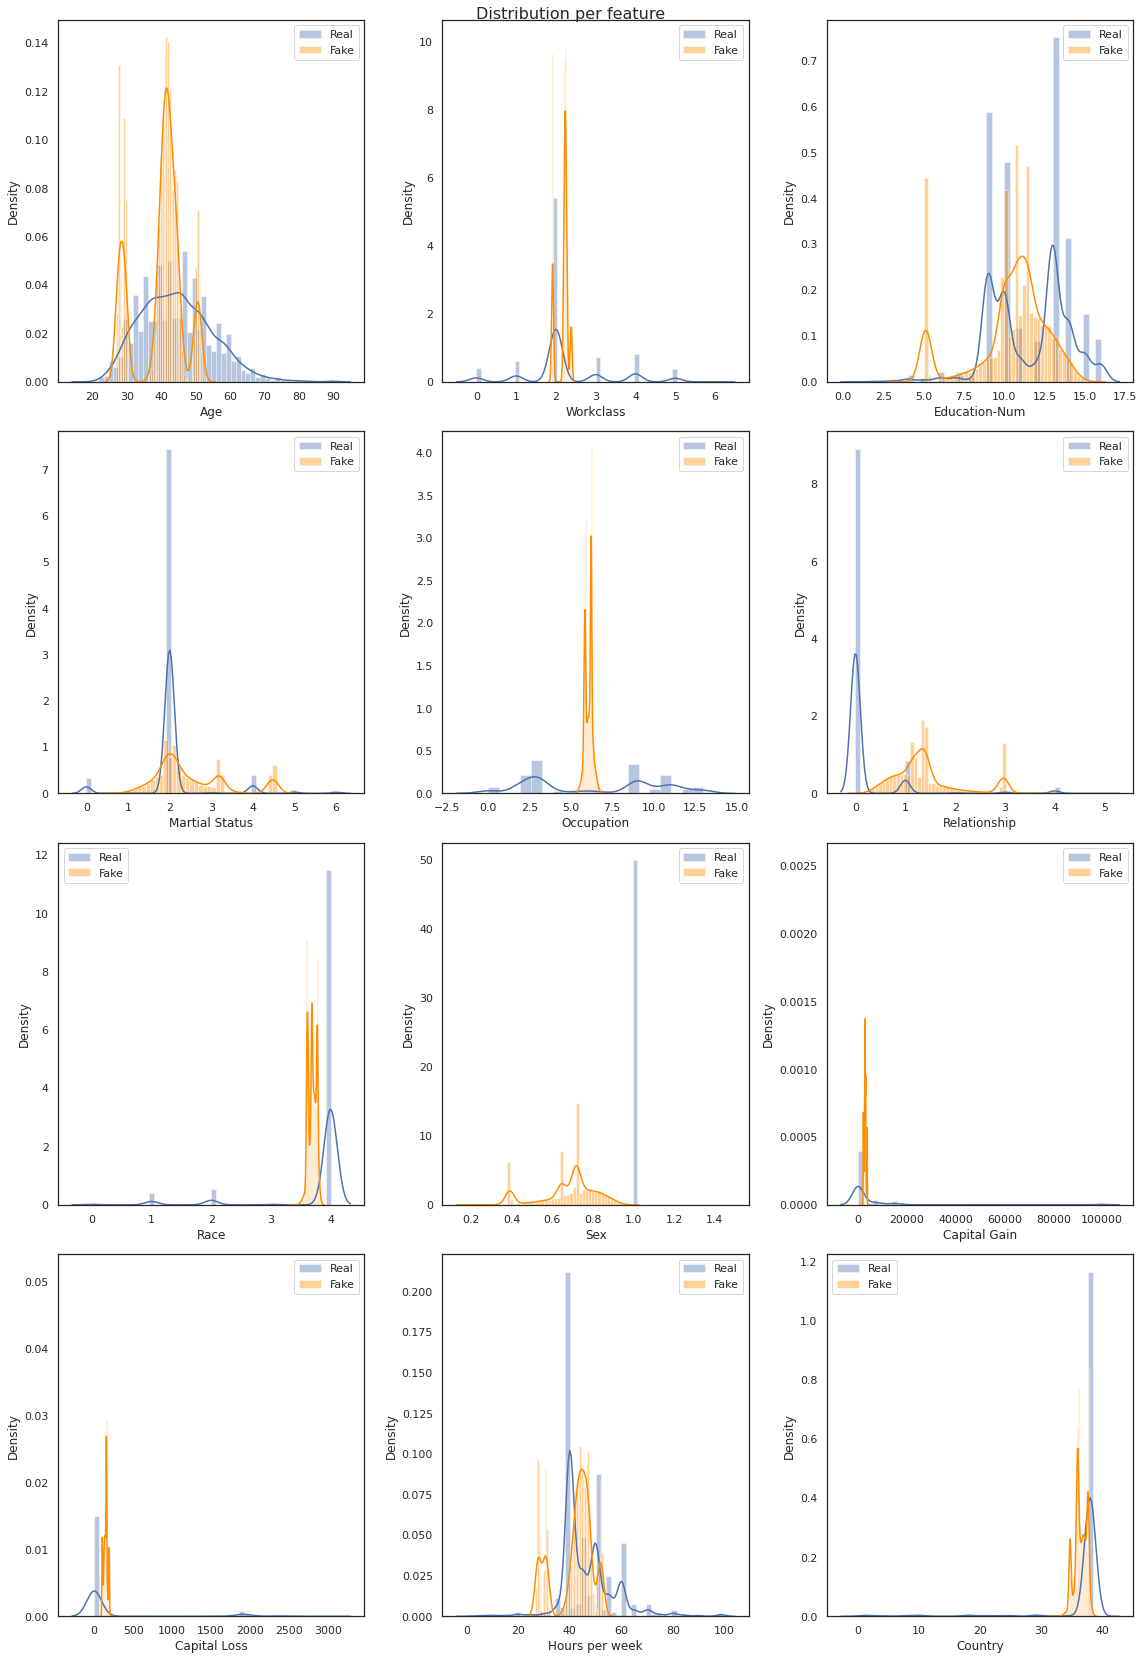

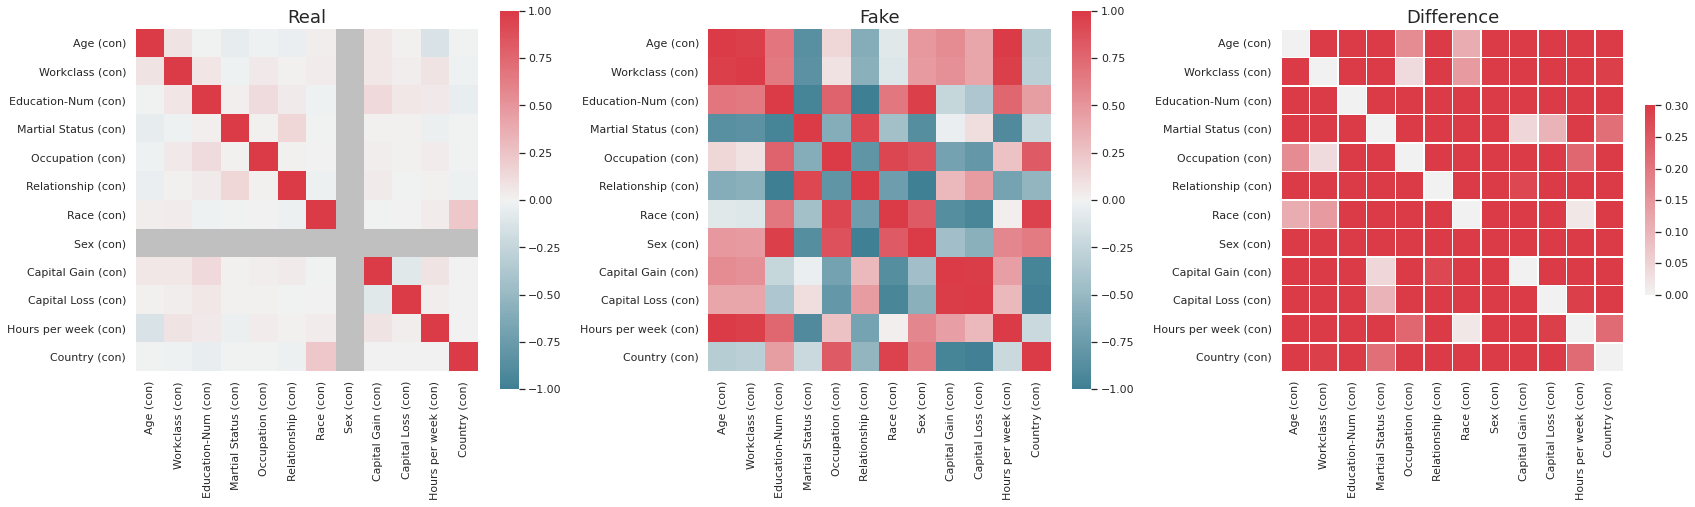

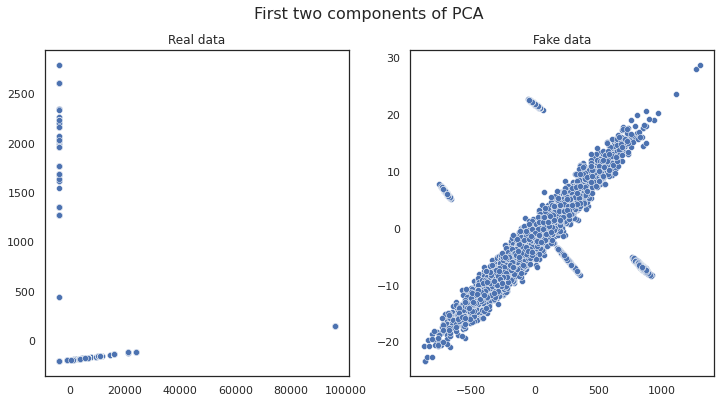

In [26]:
# Random sampling from the MDN

# High income, male
# HACK: protecte attribute is column 7
mask = (y == 1) & (X[:, 7] == 1)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.ones((num_samples, 1))
curr_protected = np.ones((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

# Check accuracy with generated data

In [27]:
# Generate data
num_samples = 100000
curr_target = np.random.randint(0, 2, num_samples)
curr_protected = np.random.randint(0, 2, num_samples)
print(curr_protected.shape)

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
# X2 = scaler.inverse_transform(xhat)
X2 = xhat
y2 = curr_target

(100000,)


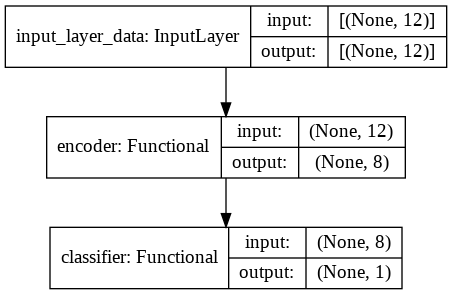

In [28]:
# Make classifier model
input_data2 = keras.Input(shape=(n_dim,), name='input_layer_data')

enc2 = encoder(n_dim, latent_dim)
clf2 = classifier(latent_dim)

model2 = tf.keras.Model(
			inputs=input_data2,
			outputs=clf2(enc2(input_data2)),
			name="simple_classifier")

# plot the model
tf.keras.utils.plot_model(model2, 'model2.png', show_shapes=True)

In [29]:
# Train with generated data
opt2 = keras.optimizers.Adam(learning_rate=learning_rate)
model2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=[tf.keras.metrics.binary_accuracy])
hist2 = model2.fit(X2, y2, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
704/704 [==============================] - 2s 2ms/step - loss: 0.5647 - binary_accuracy: 0.7019 - val_loss: 0.4755 - val_binary_accuracy: 0.7758
Epoch 2/50
704/704 [==============================] - 1s 2ms/step - loss: 0.4660 - binary_accuracy: 0.7858 - val_loss: 0.4513 - val_binary_accuracy: 0.7977
Epoch 3/50
704/704 [==============================] - 1s 2ms/step - loss: 0.4493 - binary_accuracy: 0.7954 - val_loss: 0.4405 - val_binary_accuracy: 0.7980
Epoch 4/50
704/704 [==============================] - 1s 2ms/step - loss: 0.4389 - binary_accuracy: 0.7985 - val_loss: 0.4374 - val_binary_accuracy: 0.7750
Epoch 5/50
704/704 [==============================] - 1s 2ms/step - loss: 0.4280 - binary_accuracy: 0.7981 - val_loss: 0.4238 - val_binary_accuracy: 0.7845
Epoch 6/50
704/704 [==============================] - 1s 2ms/step - loss: 0.4185 - binary_accuracy: 0.8004 - val_loss: 0.4242 - val_binary_accuracy: 0.8345
Epoch 7/50
704/704 [==============================] - 1s 2ms/ste

Test Accuracy: 0.8268592909265129
Test Accuracy: 0.5995430087712833
              precision    recall  f1-score   support

         0.0       0.80      0.63      0.70     10258
         1.0       0.31      0.52      0.39      3309

    accuracy                           0.60     13567
   macro avg       0.56      0.57      0.55     13567
weighted avg       0.68      0.60      0.63     13567



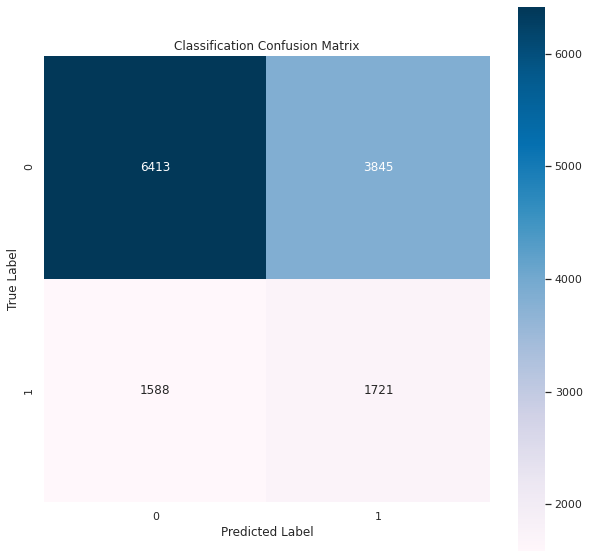

In [30]:
# Check accuracy

# Encode the input data
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy:', acc)

# ------------------------------

z = enc2(Xtest)

# Classify the latent code
ypred = clf2(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy:', acc)



print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()

# Now try combining the original training data with the generated data to train a classifier.

In [55]:
# Generate data
num_samples = 6000
curr_target = np.ones((num_samples,)) #np.random.randint(0, 2, num_samples)
curr_protected = np.random.randint(0, 2, num_samples)
print(curr_protected.shape)

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
# X2 = scaler.inverse_transform(xhat)
X3 = xhat
y3 = curr_target

(6000,)


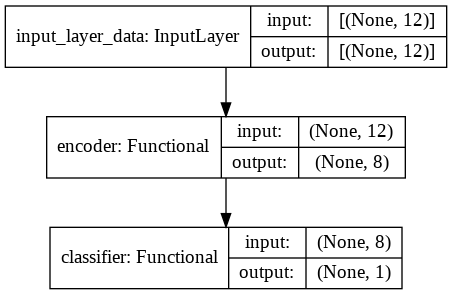

In [56]:
# Make classifier model
input_data3 = keras.Input(shape=(n_dim,), name='input_layer_data')

enc3 = encoder(n_dim, latent_dim)
clf3 = classifier(latent_dim)

model3 = tf.keras.Model(
			inputs=input_data3,
			outputs=clf3(enc3(input_data3)),
			name="simple_classifier2")

# plot the model
tf.keras.utils.plot_model(model3, 'model3.png', show_shapes=True)

In [57]:

# Combine original and generated data
X4 = np.concatenate((Xtrain, X3), axis=0)
y4 = np.concatenate((ytrain, y3))
print(X4.shape, y4.shape)

(37655, 12) (37655,)


In [58]:
# Train
opt3 = keras.optimizers.Adam(learning_rate=learning_rate)
model3.compile(optimizer=opt3, loss='binary_crossentropy', metrics=[tf.keras.metrics.binary_accuracy])
hist3 = model3.fit(X4, y4, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
265/265 [==============================] - 1s 3ms/step - loss: 0.5616 - binary_accuracy: 0.7225 - val_loss: 1.1933 - val_binary_accuracy: 0.2363
Epoch 2/50
265/265 [==============================] - 1s 2ms/step - loss: 0.4907 - binary_accuracy: 0.7662 - val_loss: 0.9839 - val_binary_accuracy: 0.4814
Epoch 3/50
265/265 [==============================] - 1s 2ms/step - loss: 0.4436 - binary_accuracy: 0.7909 - val_loss: 0.7705 - val_binary_accuracy: 0.5791
Epoch 4/50
265/265 [==============================] - 1s 2ms/step - loss: 0.4012 - binary_accuracy: 0.8157 - val_loss: 0.4632 - val_binary_accuracy: 0.8216
Epoch 5/50
265/265 [==============================] - 1s 2ms/step - loss: 0.3693 - binary_accuracy: 0.8278 - val_loss: 0.2034 - val_binary_accuracy: 0.9381
Epoch 6/50
265/265 [==============================] - 0s 2ms/step - loss: 0.3525 - binary_accuracy: 0.8387 - val_loss: 0.1324 - val_binary_accuracy: 0.9926
Epoch 7/50
265/265 [==============================] - 1s 2ms/ste

Test Accuracy: 0.8268592909265129
Test Accuracy 2: 0.5995430087712833
Test Accuracy 3: 0.8433699417704724
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     10258
         1.0       0.70      0.62      0.66      3309

    accuracy                           0.84     13567
   macro avg       0.79      0.77      0.78     13567
weighted avg       0.84      0.84      0.84     13567



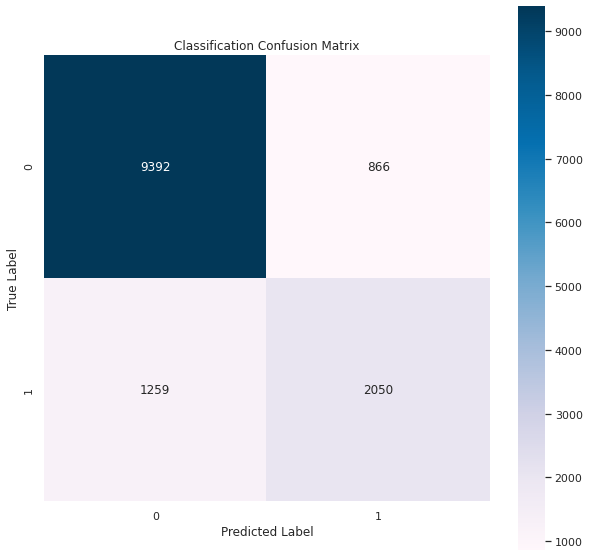

In [59]:
# Check accuracy

# Encode the input data
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy:', acc)

# ------------------------------

# Encode the input data
z = enc2(Xtest)

# Classify the latent code
ypred = clf2(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy 2:', acc)

# ------------------------------

z = enc3(Xtest)

# Classify the latent code
ypred = clf3(z)
ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy 3:', acc)

print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()